<a href="https://colab.research.google.com/github/aquangnguyen1992/Advanced_Data_Science_Capstone/blob/master/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Get the dataset from Kaggle***

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
!kaggle competitions download -c ieee-fraud-detection
!unzip \*.zip  && rm *.zip

  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 106MB/s]
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 109MB/s]
 73% 38.0M/52.2M [00:00<00:00, 100MB/s] 
100% 52.2M/52.2M [00:00<00:00, 149MB/s]
 70% 41.0M/58.3M [00:00<00:00, 152MB/s]
100% 58.3M/58.3M [00:00<00:00, 148MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 143MB/s]
Archive:  test_transaction.csv.zip
replace test_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N

Archive:  train_identity.csv.zip

Archive:  test_identity.csv.zip

Archive:  sample_submission.csv.zip

Archive:  train_transaction.csv.zip

5 archives were successfully processed.


# ***Analyzing the dataset and doing the cleansing***

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import copy
import os
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
os.chdir("/content")
dataset_transaction = pd.read_csv('train_transaction.csv')
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
dataset_identity = pd.read_csv('train_identity.csv')
dataset_identity.head(5)
saved_columns= np.array(dataset_identity.columns)

In [ ]:
dataset_identity.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [ ]:
dataset_transaction.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

In [7]:
#Data transaction
float_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
to_remove_NaN_dataset_transaction = []
removed = 0
for column in float_columns:
  count_NaN = np.sum(np.isnan(dataset_transaction[column].values))
  if count_NaN/len(dataset_transaction[column].values) > 0.75:
    to_remove_NaN_dataset_transaction.append(column)
    dataset_transaction.pop(column)
    removed += 1
print("Removed: " + str(removed))

Removed: 167


In [8]:
# Dataset Identity
float_columns = dataset_identity.columns[np.where(dataset_identity.dtypes == np.dtype('float64'))].to_list()
to_remove_NaN_dataset_identity = []
removed = 0
for column in float_columns:
  count_NaN = np.sum(np.isnan(dataset_identity[column].values))
  if count_NaN/len(dataset_identity[column]) > 0.75:
    to_remove_NaN_dataset_identity.append(column)
    dataset_identity.pop(column)
    removed += 1
print("Removed: " + str(removed))


Removed: 7


In [9]:
to_remove_id = ['DeviceInfo', 'id_30', 'id_31', 'id_33']
for column in to_remove_id:
  dataset_identity.pop(column)

In [10]:
merged_data = pd.merge(left=dataset_transaction, right=dataset_identity, how='left', left_on='TransactionID', right_on='TransactionID')

dataset_transaction = None
dataset_identity = None
merged_data.shape

(590540, 256)

In [ ]:
merged_data.tail(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,...,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_23,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,56.0,56.0,56.0,T,T,...,0.0,0.0,47.950001,47.950001,47.950001,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,T,F,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,T,F,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,3.0,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,22.0,22.0,0.0,22.0,0.0,22.0,22.0,22.0,T,T,...,0.0,117.0,317.500000,669.500000,317.500000,0.0,2234.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590539,3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,credit,299.0,87.0,NaN,gmail.com,NaN,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,1.0,0.0,1.0,0.0,1.0,T,F,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,279.950012,279.950012,279.950012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Check NaN, Null, and OneHotEncoding**

In [11]:
dataset_transaction = copy.copy(merged_data)
merged_data = None
dataset_identity = None

float_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('O'))].to_list()

skip_int_columns = ['TransactionID', 'isFraud']
for column in skip_int_columns:
  int_columns.remove(column)

skip_obj_colums = ['']
cache = dict()
print(len(float_columns), len(int_columns), len(obj_columns))

225 2 27


In [12]:
def normalization_data(X, indices):
  X_out = copy.copy(X)
  X_temp = X[indices]
  max_X = np.max(X_temp)
  min_X = np.min(X_temp)
  mean_X = np.mean(X_temp)
  X_out.iloc[indices] = (X_temp - mean_X)/(max_X - min_X)
  X_out.iloc[np.where(np.isnan(X_out))[0]] = 0.0

  return min_X, max_X, mean_X, X_out.astype('float16')

In [ ]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,...,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_23,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType
0,2987000,0,86400,-0.002083,W,13926,0.000000,-0.024384,discover,-0.418213,credit,0.055145,0.002167,-0.009674,NaN,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,-0.126709,-0.184814,-0.170166,T,T,...,-0.000076,-0.000710,-0.004433,-0.00576,-0.005566,-0.001171,-0.000975,-0.001647,-0.000177,-0.000404,-0.000272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.000000,NaN,NaN,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,-0.003321,W,2755,0.082886,-0.024384,mastercard,-0.709961,credit,0.077881,0.002167,0.000000,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,-0.141479,0.000000,-0.170166,NaN,NaN,...,-0.000076,-0.000710,-0.004433,-0.00576,-0.005566,-0.001171,-0.001847,-0.001647,-0.000177,-0.000404,-0.000272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.000000,NaN,NaN,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,-0.002380,W,4663,0.254883,-0.024384,visa,-0.242920,debit,0.089233,0.002167,0.016388,outlook.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,-0.141479,0.232910,0.157227,T,T,...,-0.000076,-0.000710,-0.004433,-0.00576,-0.005566,-0.001171,-0.001847,-0.001647,-0.000177,-0.000404,-0.000272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.000000,NaN,NaN,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,-0.002663,W,18132,0.408936,-0.024384,mastercard,-0.600586,debit,0.421143,0.002167,0.000000,yahoo.com,NaN,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,-0.045654,0.000000,-0.054840,NaN,NaN,...,-0.000076,0.001739,-0.004433,-0.00576,-0.005566,-0.000638,0.008629,0.006374,-0.000177,-0.000404,-0.000272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.000000,NaN,NaN,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,-0.002663,H,4497,0.302979,-0.024384,mastercard,-0.709961,credit,0.293701,0.002167,0.000000,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,-0.000076,-0.000710,-0.004433,-0.00576,-0.005566,-0.001171,-0.001847,-0.001647,-0.000177,-0.000404,-0.000272,0.101685,-0.103943,0.0,0.0,0.0,0.0,0.0,0.0,0.025467,NotFound,0.0,-0.098206,New,NotFound,-0.181763,0.0,0.330811,-0.463135,NaN,NaN,New,NotFound,0.171631,match_status:2,T,F,T,T,mobile


In [13]:
# Task 1: Detect the columns with NaN and code it with an extra features
# Task 2: Apply normalizationn
# Task 3: Remove the irrelevant columns
for column in float_columns:
  # Set to float 16
  dataset_transaction[column].astype('float32')

  # Code the NaN column for every features
  #dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], dataset_transaction[column] = normalization_data(X, indices)
  dataset_transaction[column].astype('float16')

In [ ]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,...,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_23,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType
0,2987000,0,86400,-0.002083,W,13926,0.000000,-0.024384,discover,-0.418213,credit,0.055145,0.002167,-0.009674,NaN,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,-0.126709,-0.184814,-0.170166,T,T,...,-0.000076,-0.000710,-0.004433,-0.00576,-0.005566,-0.001171,-0.000975,-0.001647,-0.000177,-0.000404,-0.000272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.000000,NaN,NaN,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,-0.003321,W,2755,0.082886,-0.024384,mastercard,-0.709961,credit,0.077881,0.002167,0.000000,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,-0.141479,0.000000,-0.170166,NaN,NaN,...,-0.000076,-0.000710,-0.004433,-0.00576,-0.005566,-0.001171,-0.001847,-0.001647,-0.000177,-0.000404,-0.000272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.000000,NaN,NaN,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,-0.002380,W,4663,0.254883,-0.024384,visa,-0.242920,debit,0.089233,0.002167,0.016388,outlook.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,-0.141479,0.232910,0.157227,T,T,...,-0.000076,-0.000710,-0.004433,-0.00576,-0.005566,-0.001171,-0.001847,-0.001647,-0.000177,-0.000404,-0.000272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.000000,NaN,NaN,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,-0.002663,W,18132,0.408936,-0.024384,mastercard,-0.600586,debit,0.421143,0.002167,0.000000,yahoo.com,NaN,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,-0.045654,0.000000,-0.054840,NaN,NaN,...,-0.000076,0.001739,-0.004433,-0.00576,-0.005566,-0.000638,0.008629,0.006374,-0.000177,-0.000404,-0.000272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.000000,NaN,NaN,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,-0.002663,H,4497,0.302979,-0.024384,mastercard,-0.709961,credit,0.293701,0.002167,0.000000,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,-0.000076,-0.000710,-0.004433,-0.00576,-0.005566,-0.001171,-0.001847,-0.001647,-0.000177,-0.000404,-0.000272,0.101685,-0.103943,0.0,0.0,0.0,0.0,0.0,0.0,0.025467,NotFound,0.0,-0.098206,New,NotFound,-0.181763,0.0,0.330811,-0.463135,NaN,NaN,New,NotFound,0.171631,match_status:2,T,F,T,T,mobile


In [14]:
for column in int_columns:
  # Set to int 32
  dataset_transaction[column].astype('float32')

  # Code the NaN feature
  #dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], dataset_transaction[column] = normalization_data(X, indices)

In [ ]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,...,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_23,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType
0,2987000,0,-0.463379,-0.002083,W,0.231445,0.000000,-0.024384,discover,-0.418213,credit,0.055145,0.002167,-0.009674,NaN,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,-0.126709,-0.184814,-0.170166,T,T,...,-0.000076,-0.000710,-0.004433,-0.00576,-0.005566,-0.001171,-0.000975,-0.001647,-0.000177,-0.000404,-0.000272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.000000,NaN,NaN,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,-0.463379,-0.003321,W,-0.410645,0.082886,-0.024384,mastercard,-0.709961,credit,0.077881,0.002167,0.000000,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,-0.141479,0.000000,-0.170166,NaN,NaN,...,-0.000076,-0.000710,-0.004433,-0.00576,-0.005566,-0.001171,-0.001847,-0.001647,-0.000177,-0.000404,-0.000272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.000000,NaN,NaN,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,-0.463379,-0.002380,W,-0.301025,0.254883,-0.024384,visa,-0.242920,debit,0.089233,0.002167,0.016388,outlook.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,-0.141479,0.232910,0.157227,T,T,...,-0.000076,-0.000710,-0.004433,-0.00576,-0.005566,-0.001171,-0.001847,-0.001647,-0.000177,-0.000404,-0.000272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.000000,NaN,NaN,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,-0.463379,-0.002663,W,0.473389,0.408936,-0.024384,mastercard,-0.600586,debit,0.421143,0.002167,0.000000,yahoo.com,NaN,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,-0.045654,0.000000,-0.054840,NaN,NaN,...,-0.000076,0.001739,-0.004433,-0.00576,-0.005566,-0.000638,0.008629,0.006374,-0.000177,-0.000404,-0.000272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.000000,NaN,NaN,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,-0.463379,-0.002663,H,-0.310547,0.302979,-0.024384,mastercard,-0.709961,credit,0.293701,0.002167,0.000000,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,-0.000076,-0.000710,-0.004433,-0.00576,-0.005566,-0.001171,-0.001847,-0.001647,-0.000177,-0.000404,-0.000272,0.101685,-0.103943,0.0,0.0,0.0,0.0,0.0,0.0,0.025467,NotFound,0.0,-0.098206,New,NotFound,-0.181763,0.0,0.330811,-0.463135,NaN,NaN,New,NotFound,0.171631,match_status:2,T,F,T,T,mobile


In [15]:
from sklearn.preprocessing import OneHotEncoder

encoded_column = 0
for column in obj_columns:
  ohc = OneHotEncoder()
  dataset_transaction.loc[np.where(dataset_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.fit_transform(dataset_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(dataset_transaction[column].astype('str'))))])
  dataset_transaction = pd.concat([dataset_transaction, pd_encoded], axis=1)
  cache[column] = dataset_transaction[column].values.reshape(-1,1)
  encoded_column += len(pd_encoded.columns)

print("Encoded columns: " + str(encoded_column))
for column in obj_columns:
  try:
    dataset_transaction.pop(column)
  except KeyError:
    pass


Encoded columns: 207


In [ ]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,...,id_15_0,id_15_1,id_15_2,id_15_3,id_16_0,id_16_1,id_16_2,id_23_0,id_23_1,id_23_2,id_23_3,id_27_0,id_27_1,id_27_2,id_28_0,id_28_1,id_28_2,id_29_0,id_29_1,id_29_2,id_34_0,id_34_1,id_34_2,id_34_3,id_34_4,id_35_0,id_35_1,id_35_2,id_36_0,id_36_1,id_36_2,id_37_0,id_37_1,id_37_2,id_38_0,id_38_1,id_38_2,DeviceType_0,DeviceType_1,DeviceType_2
0,2987000,0,-0.463379,-0.002083,0.231445,0.000000,-0.024384,-0.418213,0.055145,0.002167,-0.009674,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,-0.126709,-0.184814,-0.170166,0.000055,-0.00565,-0.008675,0.025589,0.020508,-0.005077,-0.008095,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
1,2987001,0,-0.463379,-0.003321,-0.410645,0.082886,-0.024384,-0.709961,0.077881,0.002167,0.000000,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,-0.141479,0.000000,-0.170166,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
2,2987002,0,-0.463379,-0.002380,-0.301025,0.254883,-0.024384,-0.242920,0.089233,0.002167,0.016388,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,-0.141479,0.232910,0.157227,0.000055,-0.00565,-0.008675,0.025589,0.020508,-0.005077,-0.008095,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
3,2987003,0,-0.463379,-0.002663,0.473389,0.408936,-0.024384,-0.600586,0.421143,0.002167,0.000000,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,-0.045654,0.000000,-0.054840,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
4,2987004,0,-0.463379,-0.002663,-0.310547,0.302979,-0.024384,-0.709961,0.293701,0.002167,0.000000,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1


In [ ]:
print(np.any(np.isnan(dataset_transaction)), np.any(dataset_transaction.isnull()))

False False


**Apply Seaborn to preliminary analyze the dataset**

In [16]:
out = ['isFraud']
for column in dataset_transaction.columns:
  if column.find('R_emaildomain') != -1:
    out.append(column)
  if column.find('P_emaildomain') != -1:
    out.append(column)
print(out)

['isFraud', 'P_emaildomain_0', 'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'P_emaildomain_4', 'P_emaildomain_5', 'P_emaildomain_6', 'P_emaildomain_7', 'P_emaildomain_8', 'P_emaildomain_9', 'P_emaildomain_10', 'P_emaildomain_11', 'P_emaildomain_12', 'P_emaildomain_13', 'P_emaildomain_14', 'P_emaildomain_15', 'P_emaildomain_16', 'P_emaildomain_17', 'P_emaildomain_18', 'P_emaildomain_19', 'P_emaildomain_20', 'P_emaildomain_21', 'P_emaildomain_22', 'P_emaildomain_23', 'P_emaildomain_24', 'P_emaildomain_25', 'P_emaildomain_26', 'P_emaildomain_27', 'P_emaildomain_28', 'P_emaildomain_29', 'P_emaildomain_30', 'P_emaildomain_31', 'P_emaildomain_32', 'P_emaildomain_33', 'P_emaildomain_34', 'P_emaildomain_35', 'P_emaildomain_36', 'P_emaildomain_37', 'P_emaildomain_38', 'P_emaildomain_39', 'P_emaildomain_40', 'P_emaildomain_41', 'P_emaildomain_42', 'P_emaildomain_43', 'P_emaildomain_44', 'P_emaildomain_45', 'P_emaildomain_46', 'P_emaildomain_47', 'P_emaildomain_48', 'P_emaildomain_49'

In [17]:
#columns_to_analyze = ['isFraud', 'DeviceType_0', 'DeviceType_1', 'DeviceType_2', 'id_15_0', 'id_15_1', 'id_15_2', 'id_15_3']#, 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3', 'P_emaildomain_4', 'addr1', 'addr2', 'dist1', 'dist2', 'card1', 'card2', 'card3']
columns_to_analyze = out

analyzing_data = dataset_transaction[columns_to_analyze]

In [18]:
corr = analyzing_data.corr()
to_display = False

if to_display:
  mask = np.triu(np.ones_like(corr, dtype=np.bool))
  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [19]:
# Remove the weak correlation features
col = corr.columns
is_fraud = np.where(col=='isFraud')[0][0]
col = col.to_list()
col.pop(is_fraud)
to_remove = []
for each_col in col:
  if abs(corr['isFraud'][each_col]) < 0.005: # Weak correlation
    to_remove.append(each_col)
    a = dataset_transaction.pop(each_col)
print(len(to_remove))
analyzing_data = None


dataset_transaction.head(5)

88


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,...,id_15_0,id_15_1,id_15_2,id_15_3,id_16_0,id_16_1,id_16_2,id_23_0,id_23_1,id_23_2,id_23_3,id_27_0,id_27_1,id_27_2,id_28_0,id_28_1,id_28_2,id_29_0,id_29_1,id_29_2,id_34_0,id_34_1,id_34_2,id_34_3,id_34_4,id_35_0,id_35_1,id_35_2,id_36_0,id_36_1,id_36_2,id_37_0,id_37_1,id_37_2,id_38_0,id_38_1,id_38_2,DeviceType_0,DeviceType_1,DeviceType_2
0,2987000,0,-0.463379,-0.002083,0.231445,0.000000,-0.024384,-0.418213,0.055145,0.002167,-0.009674,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,-0.126709,-0.184814,-0.170166,0.000055,-0.00565,-0.008675,0.025589,0.020508,-0.005077,-0.008095,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
1,2987001,0,-0.463379,-0.003321,-0.410645,0.082886,-0.024384,-0.709961,0.077881,0.002167,0.000000,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,-0.141479,0.000000,-0.170166,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
2,2987002,0,-0.463379,-0.002380,-0.301025,0.254883,-0.024384,-0.242920,0.089233,0.002167,0.016388,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,-0.141479,0.232910,0.157227,0.000055,-0.00565,-0.008675,0.025589,0.020508,-0.005077,-0.008095,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
3,2987003,0,-0.463379,-0.002663,0.473389,0.408936,-0.024384,-0.600586,0.421143,0.002167,0.000000,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,-0.045654,0.000000,-0.054840,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
4,2987004,0,-0.463379,-0.002663,-0.310547,0.302979,-0.024384,-0.709961,0.293701,0.002167,0.000000,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1


# ***Creat the train/val dataset***

In [20]:
# Create a copy
dataset = copy.copy(dataset_transaction)

# Remove the irrelevant columns
a = dataset.pop('TransactionID')
dataset.head(5)

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,...,id_15_0,id_15_1,id_15_2,id_15_3,id_16_0,id_16_1,id_16_2,id_23_0,id_23_1,id_23_2,id_23_3,id_27_0,id_27_1,id_27_2,id_28_0,id_28_1,id_28_2,id_29_0,id_29_1,id_29_2,id_34_0,id_34_1,id_34_2,id_34_3,id_34_4,id_35_0,id_35_1,id_35_2,id_36_0,id_36_1,id_36_2,id_37_0,id_37_1,id_37_2,id_38_0,id_38_1,id_38_2,DeviceType_0,DeviceType_1,DeviceType_2
0,0,-0.463379,-0.002083,0.231445,0.000000,-0.024384,-0.418213,0.055145,0.002167,-0.009674,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,-0.126709,-0.184814,-0.170166,0.000055,-0.00565,-0.008675,0.025589,0.020508,-0.005077,-0.008095,-0.003464,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
1,0,-0.463379,-0.003321,-0.410645,0.082886,-0.024384,-0.709961,0.077881,0.002167,0.000000,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,-0.141479,0.000000,-0.170166,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
2,0,-0.463379,-0.002380,-0.301025,0.254883,-0.024384,-0.242920,0.089233,0.002167,0.016388,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,-0.141479,0.232910,0.157227,0.000055,-0.00565,-0.008675,0.025589,0.020508,-0.005077,-0.008095,-0.003464,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
3,0,-0.463379,-0.002663,0.473389,0.408936,-0.024384,-0.600586,0.421143,0.002167,0.000000,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,-0.045654,0.000000,-0.054840,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
4,0,-0.463379,-0.002663,-0.310547,0.302979,-0.024384,-0.709961,0.293701,0.002167,0.000000,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1


In [21]:
from sklearn.model_selection import train_test_split

Y = dataset['isFraud']
dataset.pop('isFraud')
X = dataset
X_train = X
Y_train = Y

Percentage of Fraud: 3.5%


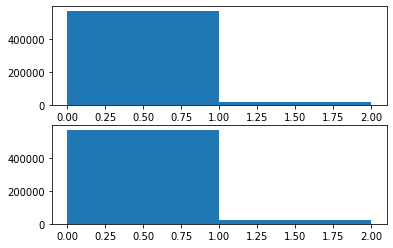

In [22]:
plt.subplot(211)
plt.hist(Y_train, bins=[0,1,2])

plt.subplot(212)
plt.hist(Y_train, bins=[0,1,2])

fraud_count = np.unique(Y_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

**Downsampling and upsampling**

In [23]:
downsampling_factor = 1
indices_1 = np.argwhere(np.array(Y_train)==1)
indices_0_new = np.argwhere(np.array(Y_train)==0)
indices = np.arange(0,len(indices_0_new),downsampling_factor)
indices_0_new = indices_0_new[indices]

print(indices_0_new.shape)

upsampling_factor = 10
indices_1_new = indices_1
for i in range(upsampling_factor):
  indices_1_new = np.concatenate((indices_1_new, indices_1), axis=0)

indices_0_new = np.concatenate((indices_1_new, indices_0_new), axis=0)

indices_0_new = tf.random.shuffle(indices_0_new)

X_new = np.array(X_train)[indices_0_new]
Y_new = np.array(Y_train)[indices_0_new]

X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, test_size=0.01)

X_to_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[2]))
Y_to_train = np.squeeze(Y_train, axis=1)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[2]))
Y_test = np.squeeze(Y_test, axis=1)


print(X_to_train.shape, X_test.shape)

(569877, 1)
(789198, 346) (7972, 346)


**Check the imbalane of the train/test dataset**

Percentage of Fraud: 28.51%


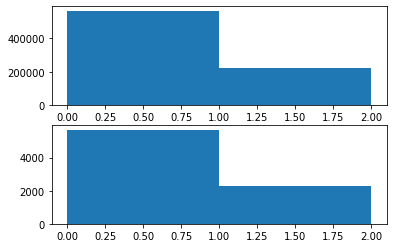

In [24]:
X_new = None
Y_new = None

plt.subplot(211)
plt.hist(Y_to_train, bins=[0,1,2])

plt.subplot(212)
plt.hist(Y_test, bins=[0,1,2])

X_train = None
Y_train = None
X = None
Y = None

fraud_count = np.unique(Y_to_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

# ***The model using NN***

In [25]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [26]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def create_model(dense1=128, dense2=64, dense3=32, dropout_rate=0.4, l1_rate=0.001, l2_rate=0.001, init_std=0.01, lr=0.001):
  out_model = Sequential()
  
  out_model.add(Dense(dense1, activation='relu',
                      input_shape=(X_to_train.shape[1],),
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(dense2, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(dense3, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(1, activation="sigmoid"))

  out_model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=[METRICS])
  
  return out_model

In [27]:
#my_model = create_model(dense1=256, dense2=256, dropout_rate=0.4, l1_rate=1e-4, l2_rate=5e-4, init_std=0.1, lr=0.00008)
my_model = create_model(dense1=64, dense2=128, dense3=256, dropout_rate=0.4, l1_rate=3e-4, l2_rate=5e-4, init_std=0.01, lr=0.00001)
#my_model = tf.keras.models.load_model('./best_model.h5')
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                22208     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               3

In [28]:
BATCH_SIZE = 256
NB_EPOCH = 2000
PATIENCE = 100

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=PATIENCE, verbose=0, mode='max',
    baseline=None)

best_model_hold = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model.h5', monitor='val_auc', verbose=1, save_best_only=True,
    save_weights_only=False, mode='max')

history = my_model.fit(X_to_train, Y_to_train, verbose=0,
             batch_size=BATCH_SIZE, epochs=NB_EPOCH,
             validation_split=0.01, shuffle=True,
             callbacks=[early_stop, best_model_hold])


Epoch 00001: val_auc improved from -inf to 0.85800, saving model to ./best_model.h5

Epoch 00002: val_auc improved from 0.85800 to 0.87746, saving model to ./best_model.h5

Epoch 00003: val_auc improved from 0.87746 to 0.89001, saving model to ./best_model.h5

Epoch 00004: val_auc improved from 0.89001 to 0.89818, saving model to ./best_model.h5

Epoch 00005: val_auc improved from 0.89818 to 0.90492, saving model to ./best_model.h5

Epoch 00006: val_auc improved from 0.90492 to 0.90785, saving model to ./best_model.h5

Epoch 00007: val_auc improved from 0.90785 to 0.91126, saving model to ./best_model.h5

Epoch 00008: val_auc improved from 0.91126 to 0.91538, saving model to ./best_model.h5

Epoch 00009: val_auc improved from 0.91538 to 0.91607, saving model to ./best_model.h5

Epoch 00010: val_auc improved from 0.91607 to 0.91914, saving model to ./best_model.h5

Epoch 00011: val_auc improved from 0.91914 to 0.92199, saving model to ./best_model.h5

Epoch 00012: val_auc improved from

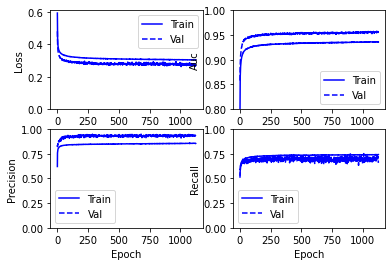

In [29]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1) 
    plt.plot(history.epoch,  history.history[metric], color='b', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='b', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)


**F1 validation (From https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model)**

In [30]:
# Save model weights to drive
!cp -r best_model.h5 '/content/gdrive/My Drive/Kaggle/best_model_20200821_METRICS.h5'

#new_model = tf.keras.models.load_model('./best_model.h5', custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU(alpha=0.01)})
new_model = tf.keras.models.load_model('./best_model.h5')
#new_model = tf.keras.models.load_model('/content/gdrive/My Drive/Kaggle/best_model_20200816_METRICS.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                22208     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               3

In [31]:
def precision_cal(y_pred, y_ref):
  pre = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    if true_pos == len(indices_positive):
      false_pos = 0
    else:
      false_pos = len(indices_positive) - true_pos

    pre = true_pos/(true_pos + false_pos)
  return pre

def recall_cal(y_pred, y_ref):
  recall = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    fals_neg = np.sum(y_ref[np.argwhere(y_pred == 0)])
       
    recall = true_pos/(true_pos + fals_neg)

  return recall

def F1_score(model, X_test, y_ref, test_size, threshold=0.5):
  test_size = test_size
  y_pred = (model.predict(X_test, batch_size=128)>threshold).astype(int)
  y_pred = np.squeeze(y_pred, axis=1)
 
  precision = precision_cal(y_pred, y_ref)
  recall = recall_cal(y_pred, y_ref)

  return precision, recall, 2*precision*recall/(precision+recall)

In [32]:
pre = []
re = []
f1 = []

pre_train = []
re_train = []
f1_train = []

threshold_value = []
indices = np.random.randint(0, len(X_to_train), size=(len(Y_test),))

for i in range(90):
  threshold_value.append(0.1+i*0.01)
  temp_pre, temp_re, temp_f1 = F1_score(new_model, X_test, Y_test, test_size=len(Y_test), threshold=threshold_value[-1])
  
  pre.append(temp_pre)
  re.append(temp_re)
  f1.append(temp_f1)

  temp_pre, temp_re, temp_f1 = F1_score(new_model, X_to_train[indices], Y_to_train[indices], test_size=len(Y_to_train[indices]), threshold=threshold_value[-1])

  pre_train.append(temp_pre)
  re_train.append(temp_re)
  f1_train.append(temp_f1)


0.847673397717296 0.846639112464651 0.844296788482835 0.24000000000000002


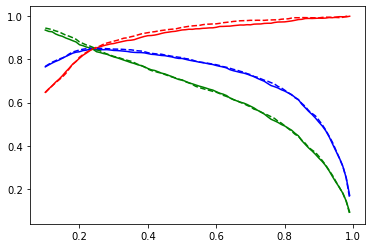

In [33]:
plt.plot(threshold_value, f1, 'b')
plt.plot(threshold_value, pre, 'r')
plt.plot(threshold_value, re, 'g')

plt.plot(threshold_value, f1_train, '--b')
plt.plot(threshold_value, pre_train, '--r')
plt.plot(threshold_value, re_train, '--g')

max_f1_indices = np.where(f1==np.max(f1))[0][0]
print(f1[max_f1_indices], f1[max_f1_indices-1], f1[max_f1_indices+1], threshold_value[max_f1_indices])

In [34]:
def plot_cm(labels, predictions, p=0.5, display=True):
  cm = confusion_matrix(labels, predictions > p)
  if display:
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
  pre = cm[1][1]/(cm[1][1] + cm[0][1])
  recall = cm[1][1]/(cm[1][1] + cm[1][0])
  f1_score = 2*pre*recall/(pre+recall)
  return pre, recall, f1_score

loss :  0.271715372800827
tp :  1608.0
fp :  109.0
tn :  5582.0
fn :  673.0
accuracy :  0.9019066691398621
precision :  0.9365171790122986
recall :  0.7049539685249329
auc :  0.958768904209137

Legitimate Transactions Detected (True Negatives):  5347
Legitimate Transactions Incorrectly Detected (False Positives):  344
Fraudulent Transactions Missed (False Negatives):  350
Fraudulent Transactions Detected (True Positives):  1931
Total Fraudulent Transactions:  2281


(0.8487912087912088, 0.8465585269618588, 0.847673397717296)

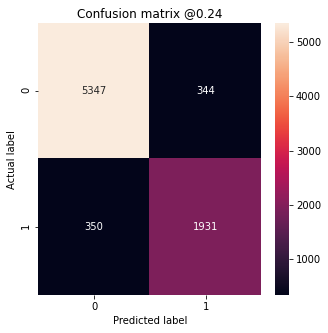

In [35]:
BATCH_SIZE = 256
baseline_results = new_model.evaluate(X_test, Y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(new_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

predictions = new_model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

plot_cm(Y_test, predictions, p=threshold_value[max_f1_indices], display=True)


0.847673397717296 0.846639112464651 0.844296788482835 0.24000000000000002


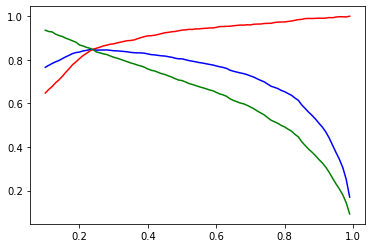

In [36]:
pre2 = []
re2 = []
f12 = []

threshold_value = []

for i in range(90):
  threshold_value.append(0.1+i*0.01)
  temp_pre, temp_re, temp_f1 = plot_cm(Y_test, predictions, p=threshold_value[-1], display=False)
  
  pre2.append(temp_pre)
  re2.append(temp_re)
  f12.append(temp_f1)

plt.plot(threshold_value, f12, 'b')
plt.plot(threshold_value, pre2, 'r')
plt.plot(threshold_value, re2, 'g')

max_f12_indices = np.where(f1==np.max(f12))[0][0]
print(f12[max_f12_indices], f12[max_f12_indices-1], f12[max_f12_indices+1], threshold_value[max_f12_indices])

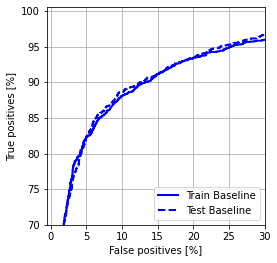

In [37]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,30])
  plt.ylim([70,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

indices = np.random.randint(0, len(X_to_train), size=(len(Y_test),))

train_prediction = new_model.predict(X_to_train[indices], batch_size=BATCH_SIZE, verbose=0)
plot_roc("Train Baseline", Y_to_train[indices], train_prediction, color='b')
plot_roc("Test Baseline", Y_test, predictions, color='b', linestyle='--')
plt.legend(loc='lower right')

Percentage of Fraud: 28.54% 28.61%


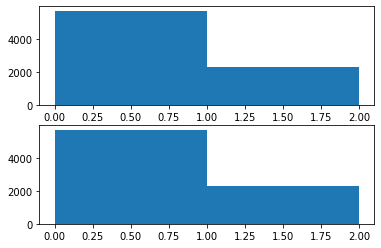

In [38]:
prediction = np.squeeze(predictions, axis=1)
threshold = threshold_value[max_f1_indices]
plt.subplot(211)
plt.hist(Y_test, bins=[0,1,2])

plt.subplot(212)
plt.hist((prediction>threshold).astype('int'), bins=[0,1,2])

fraud_predict = np.unique((prediction>threshold).astype('int'), return_counts=True)
fraud_real = np.unique(Y_test, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_predict[1][1]/np.sum(fraud_predict[1])*100,2)) + "% " + str(round(fraud_real[1][1]/np.sum(fraud_real[1])*100,2)) + "%")



# ***Output the result into a file for a validation with Kaggle***

In [39]:
import os
os.chdir("/content")
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv', names=saved_columns, header=0)
test_identity.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [40]:
dataset_transaction = None
to_remove_id = ['DeviceInfo', 'id_30', 'id_31', 'id_33']
for column in to_remove_id:
  a = test_identity.pop(column)

In [ ]:
test_identity.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,NaN,F,F,T,F,mobile
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,24.0,match_status:2,T,F,T,T,mobile
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,NaN,F,T,T,F,desktop
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,NaN,F,F,T,F,mobile
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,NaN,F,F,T,F,mobile


In [41]:
# Remove the columns in to_remove_NaN_dataset_transaction and to_remove_NaN_dataset_identity
for column in to_remove_NaN_dataset_transaction:
  test_transaction.pop(column)

for column in to_remove_NaN_dataset_identity:
  test_identity.pop(column)

In [42]:
merged_data = pd.merge(left=test_transaction, right=test_identity, how='left', left_on='TransactionID', right_on='TransactionID')

TransactionID = merged_data.pop('TransactionID')
test_transaction = None
merged_data.shape

(506691, 254)

In [43]:
test_transaction = copy.copy(merged_data)
merged_data = None
float_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('O'))].to_list()

print(len(float_columns_test), len(int_columns_test), len(obj_columns_test))

225 2 27


In [44]:
def apply_normalization(X, indices, cache_min, cache_max, cache_mean):
  X_out = copy.copy(X)
  X_out[indices] = (X_out[indices] - cache_mean)/(cache_max - cache_min)
  X_out[np.where(np.isnan(X_out))[0]] = 0.0
  return X_out.astype('float16')  


In [45]:
for column in float_columns_test:
  # Set to float 16
  test_transaction[column].astype('float32')

  # Code the NaN feature
  # test_transaction[column + "_NaN_Code"] = np.isnan(test_transaction[column].values).astype('int8')
  
  # Normalization
  X = test_transaction[column]
  indices = np.where(np.isnan(test_transaction[column]) == False)[0]
  test_transaction[column] = apply_normalization(X.to_numpy(), indices, cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'])

In [46]:
for column in int_columns_test:
  # Set to int 32
  test_transaction[column].astype('int32')

  # Code the NaN feature
  # test_transaction[column + "_NaN_Code"] = np.isnan(test_transaction[column].values).astype('int8')
  
  # Normalization
  X = test_transaction[column]
  indices = np.where(np.isnan(test_transaction[column]) == False)[0]
  test_transaction[column] = apply_normalization(X.to_numpy(), indices, cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'])

In [47]:
encoded_column = 0
for column in obj_columns_test:
  ohc = OneHotEncoder(handle_unknown='ignore')
  ohc.fit(cache[column])
  test_transaction.loc[np.where(test_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.transform(test_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(cache[column])))])
  test_transaction = pd.concat([test_transaction, pd_encoded], axis=1)
  encoded_column += len(pd_encoded.columns)

print("Encoded columns: " + str(encoded_column))


for column in obj_columns_test:
  try:
    test_transaction.pop(column)
  except KeyError:
    pass

for column in to_remove:
  try:
    test_transaction.pop(column)
  except KeyError:
    pass



Encoded columns: 207


In [ ]:
# Check if we have the same shape with the X_train
#print(test_transaction.shape, X_train.shape)
print(test_transaction.shape)

(506691, 346)


In [48]:
# Make the prediction and submit the output
threshold = threshold_value[max_f1_indices]
#threshold = 0.4
result = (new_model.predict(test_transaction)>threshold).astype('int8')
result_pd = pd.DataFrame(result, columns=['isFraud'])
data_to_file = pd.concat([TransactionID, result_pd], axis=1)
data_to_file.head(5)
data_to_file.to_csv("./submission.csv", index=False)
data_to_file.to_csv('/content/gdrive/My Drive/Kaggle/submission.csv', index=False)

In [49]:
!kaggle competitions submit -c ieee-fraud-detection -f submission.csv -m "New submission with model_20200821 with threshold {threshold}"

100% 4.83M/4.83M [00:03<00:00, 1.48MB/s]
Successfully submitted to IEEE-CIS Fraud Detection

# ***Debug zone***

In [ ]:
indices = np.where(np.isnan(a) == False)[0]
min_value, max_value, mean_value, normalized_data = normalization_data(a, indices)
print(min_value, max_value, mean_value, np.mean(normalized_data), np.min(normalized_data), np.max(normalized_data))
dataset_transaction['V331'] = normalized_data

0.0 160000.0 721.7418829164045 -2.2733716828843707e-16 -0.004510886768227528 0.9954891132317726


In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder()
a = {'a': ['Null', 'A', 'B', 'C', 'D']}
df = pd.DataFrame(a)
df
encoded = ohc.fit_transform(df['a'].values.reshape(-1,1)).toarray()    
pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=["a"+"_"+str(i) for i in range(len(np.unique(df['a'].astype('str'))))])
pd_encoded


,a_0,a_1,a_2,a_3,a_4
0,0,0,0,0,1
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,1,0


In [ ]:
b = {'a': ['Null', 'A', 'B', 'C', 'E']}
df_b = pd.DataFrame(b)
ohc_b = OneHotEncoder(handle_unknown='ignore')
ohc_b.fit(df['a'].values.reshape(-1,1))
encoded_b = ohc_b.transform(df_b['a'].values.reshape(-1,1)).toarray()    
pd_encoded_b = pd.DataFrame(encoded_b.astype('int8'), columns=["a"+"_"+str(i) for i in range(len(np.unique(df['a'].astype('str'))))])
pd_encoded_b

,a_0,a_1,a_2,a_3,a_4
0,0,0,0,0,1
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,0,0


In [ ]:
for column in obj_columns:
  dataset_transaction.loc[np.where(dataset_transaction[column].isnull())[0], column] = 'Null'
  print(column, len(np.unique(dataset_transaction[column].astype("str"))))

ProductCD 5
card4 5
card6 5
P_emaildomain 60
R_emaildomain 61
M1 3
M2 3
M3 3
M4 4
M5 3
M6 3
M7 3
M8 3
M9 3


In [ ]:
for column in obj_columns_test:
  test_transaction.loc[np.where(test_transaction[column].isnull())[0], column] = 'Null'
  print(column, len(np.unique(test_transaction[column].astype("str"))))

ProductCD 5
card4 5
card6 4
P_emaildomain 61
R_emaildomain 61
M1 3
M2 3
M3 3
M4 4
M5 3
M6 3
M7 3
M8 3
M9 3


**Train val dataset**